In [1]:
import os
from itertools import product

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import gridspec

import pandas as pd
from pingouin import mixed_anova, anova, pairwise_tukey, pairwise_ttests
from statsmodels.regression.mixed_linear_model import MixedLM

import TwoPUtils as tpu
import STX3KO_analyses as stx
from STX3KO_analyses import utilities as u

import sklearn
from sklearn.mixture import BayesianGaussianMixture as BGM


ko_mice = stx.ymaze_sess_deets.ko_mice
ctrl_mice = stx.ymaze_sess_deets.ctrl_mice


%matplotlib inline

%load_ext autoreload
%autoreload 2

rng = np.random.default_rng()

In [2]:
figdir = "/mnt/BigDisk/YMazeResults/neural/field_shifts"
os.makedirs(figdir,exist_ok=True)

In [3]:
# replication of Losconczy preprint

# https://www.biorxiv.org/content/10.1101/2021.07.02.450956v1.full.pdf

# and sheffield 

# https://www-nature-com.stanford.idm.oclc.org/articles/s41467-021-23260-3#Sec8

In [3]:


def get_field_stats(field_mask):
#     sigfield_cells = field_mask.sum(axis=0)>0
    _field_mask = np.zeros([field_mask.shape[0]+2, field_mask.shape[1]])
    _field_mask[1:-1,:]=field_mask
#     _field_mask = 1.*field_mask
#     _field_mask = _field_mask[:,sigfield_cells]
    
    rising_edges, falling_edges = np.argwhere((_field_mask[1:,:]>_field_mask[:-1,:]).T), np.argwhere((_field_mask[:-1,:]>_field_mask[1:,:]).T)
    field_widths = falling_edges[:,1]-rising_edges[:,1]
    
#     mask = field_widths>2
#     rising_edges, falling_edges, field_widths = rising_edges[mask,:], falling_edges[mask,:], field_widths[mask]
    
    num_fields = np.bincount(rising_edges[:,0])
    
#     num_fields = (_field_mask[1:, :]>_field_mask[:-1, :]).sum(axis=0)
    
    return rising_edges, falling_edges, field_widths, num_fields
    
    

def field_masks(sess, n_perms = 1000, pcnt = 99):
    
    
    
    def _run_fields(nov):
        if nov:
            trial_mask = sess.trial_info['LR']==sess.novel_arm
        else:
            trial_mask = sess.trial_info['LR']== -1*sess.novel_arm
        shuff_mat = np.zeros([1000, *sess.trial_matrices['spks'].shape[1:]])
        trial_mat = sess.trial_matrices['spks'][trial_mask,:,:]
        n_trials = trial_mat.shape[0]
        
        shuffs = rng.integers(trial_mat.shape[1], size = [n_perms, trial_mat.shape[0]])
        
        # calculate shuffles
        _tmat = 0*trial_mat
        for perm in range(n_perms):
            for trial in range(n_trials):
                _tmat[trial,:,:] = np.roll(trial_mat[trial,:,:], shuffs[perm, trial])
            shuff_mat[perm,:,:] = np.nanmean(_tmat, axis=0)
            
        thresh = np.nanpercentile(shuff_mat,pcnt, axis=0)
        field_mask = 1*(np.nanmean(trial_mat,axis=0)>thresh)
        rising_edges, falling_edges, field_widths, num_fields = get_field_stats(field_mask)
        return {'field_mask': field_mask, 
                'rising_edges': rising_edges, 
                'falling_edges': falling_edges, 
                'field_widths': field_widths,
                'num_fields': num_fields}
    
    return {'fam': _run_fields(False), 'nov': _run_fields(True)}




In [34]:
field_masks_loop = u.loop_func_over_days(field_masks, np.arange(6))
ko_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ko_mice}
ctrl_field_mask_res = {mouse:field_masks_loop(mouse) for mouse in ctrl_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', '

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [6]:
np.save('place_field_stats.npy', {'ctrl': ctrl_field_mask_res, 'ko': ko_field_mask_res})

In [4]:
_res = np.load("./place_field_stats.npy", allow_pickle=True).all()
ko_field_mask_res, ctrl_field_mask_res = _res['ko'], _res['ctrl']

(array([0.        , 0.28265825, 0.22321585, 0.17008592, 0.10625986,
        0.07417149, 0.04541469, 0.03051026, 0.02454848, 0.01367701,
        0.0117482 , 0.00859197, 0.00333158, 0.00578643]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

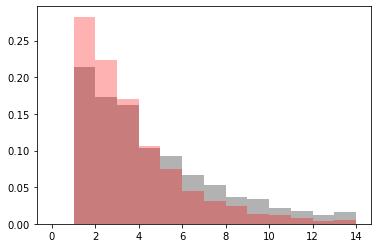

In [5]:
fig, ax = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['field_widths'])
ctrl_fw = np.concatenate(ctrl_fw)

ax.hist(ctrl_fw, bins = np.arange(15), color='black', alpha = .3, density=True)

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['field_widths'])
ko_fw = np.concatenate(ko_fw)

ax.hist(ko_fw, bins = np.arange(15), color = 'red', alpha = .3,density=True)

(array([0.        , 0.59437312, 0.28817263, 0.11745425]),
 array([0, 1, 2, 3, 4]),
 <BarContainer object of 4 artists>)

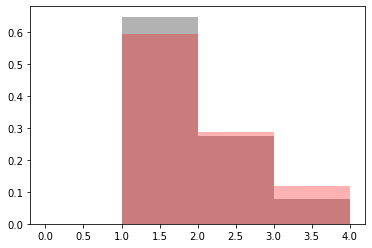

In [6]:
fig, ax = plt.subplots()
day = 0

ctrl_fw = []
for mouse in ctrl_mice:
    ctrl_fw.append(ctrl_field_mask_res[mouse][day]['fam']['num_fields'])
ctrl_fw = np.concatenate(ctrl_fw)

ax.hist(ctrl_fw[ctrl_fw>0], bins = np.arange(5), color='black', alpha = .3, density=True)

ko_fw = []
for mouse in ko_mice:
    ko_fw.append(ko_field_mask_res[mouse][day]['fam']['num_fields'])
ko_fw = np.concatenate(ko_fw)

ax.hist(ko_fw[ko_fw>0], bins = np.arange(5), color = 'red', alpha = .3,density=True)

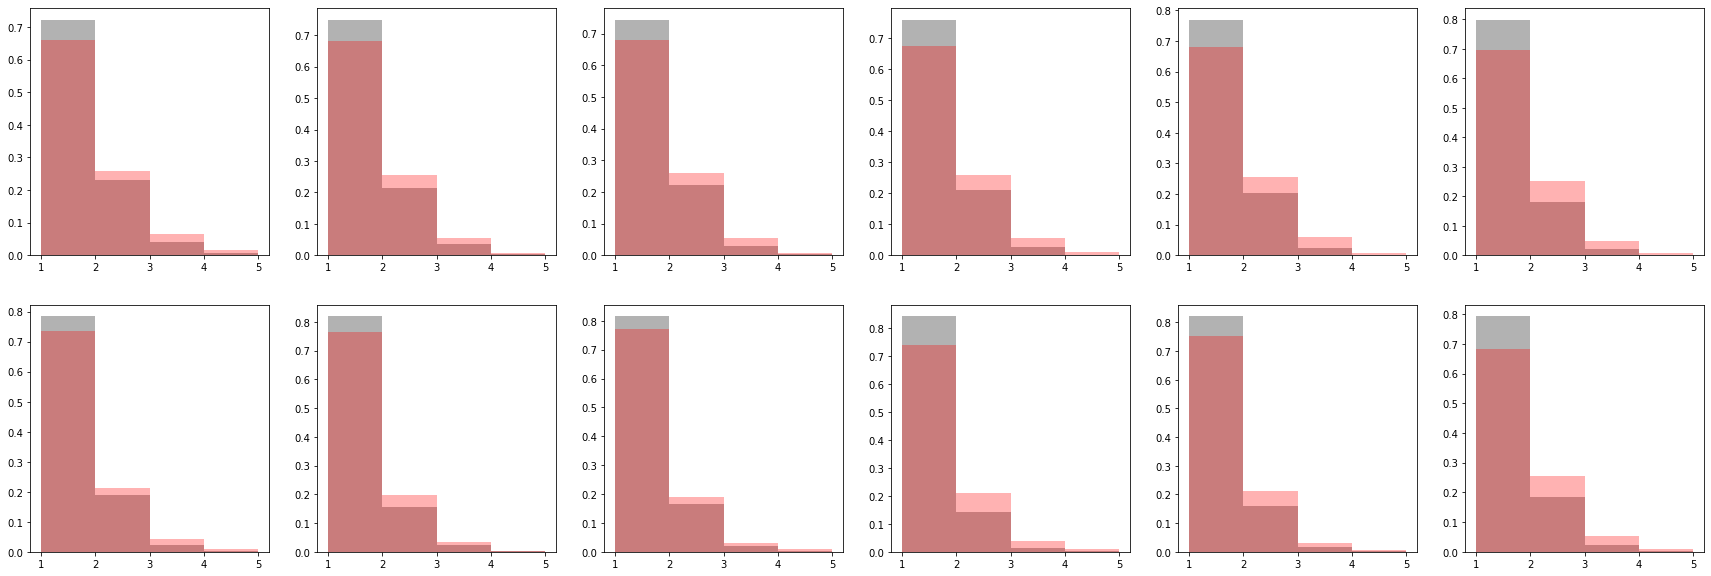

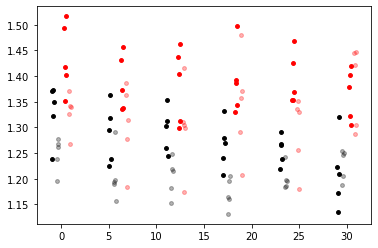

In [7]:
fig, ax = plt.subplots(2,6, figsize=[30,10])

fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'num_fields' : [],
                   'mouse': [], 
                   'intercept': []})
days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
#             dat = ctrl_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ctrl_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 
                            'day': days_z[day], 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        ax[row,day].hist(ctrl_fw, bins = np.arange(1,6), color='black', alpha = .3, density=True)
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
#             dat = ko_field_mask_res[mouse][day][novkey]['num_fields']
            fm = ko_field_mask_res[mouse][day][novkey]['field_mask'] 
            rising, falling = (fm[1:, :]>fm[:-1, :]).sum(axis=0), (fm[:-1, :]>fm[1:, :]).sum(axis=0)
            dat = np.minimum(rising, falling)
#             dat = (fm[1:, :]>fm[:-1, :]).sum(axis=0)
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 
                            'day': days_z[day], 
                            'nov': row, 
                            'num_fields': dat[dat>0].mean(), 
                            'mouse': mouse,
                            'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

        ax[row,day].hist(ko_fw, bins = np.arange(1,6), color = 'red', alpha = .3,density=True)

In [8]:
lmm_res = MixedLM(df['num_fields'], df[['ko', 'day', 'nov', 'intercept']], df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: num_fields
No. Observations: 120     Method:             REML      
No. Groups:       10      Scale:              0.0026    
Min. group size:  12      Log-Likelihood:     165.4821  
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
ko             0.117    0.024  4.880 0.000  0.070  0.163
day           -0.011    0.005 -2.462 0.014 -0.020 -0.002
nov           -0.066    0.009 -7.148 0.000 -0.084 -0.048
intercept      1.275    0.018 72.837 0.000  1.241  1.309
Group Var      0.001    0.015                           



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


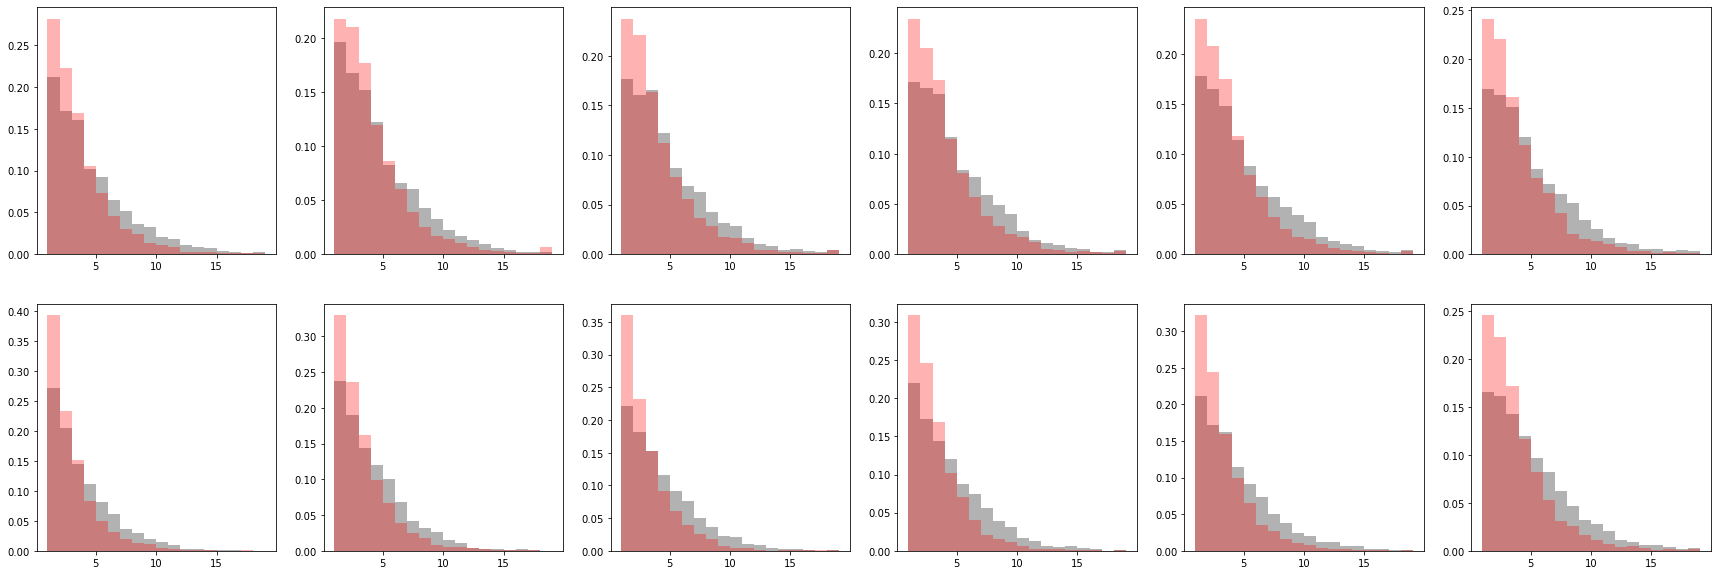

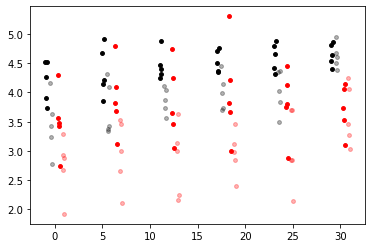

In [9]:
fig, ax = plt.subplots(2,6, figsize=[30,10])

fig_scat, ax_scat = plt.subplots()
df = pd.DataFrame({'ko': [],
                   'day': [],
                   'nov': [],
                   'fw' : [],
                   'mouse': [],
                   'intercept': []})
days_z = sp.stats.zscore(np.arange(6))
for row, novkey in enumerate([ 'fam', 'nov']):
    for day in range(6):

        ctrl_fw = []
        ctrl_mu = []
        for mouse in ctrl_mice:
            r,f  = ctrl_field_mask_res[mouse][day][novkey]['rising_edges'], ctrl_field_mask_res[mouse][day][novkey]['falling_edges']
            border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             print(dat)
            ctrl_fw.append(dat[dat>0])
            df = df.append({'ko': 0, 'day': days_z[day], 'nov': row, 
                            'fw': dat[dat>0].mean(), 'mouse': mouse, 'intercept': 1}, ignore_index=True)
            ctrl_mu.append(dat[dat>0].mean())
        ctrl_fw = np.concatenate(ctrl_fw)

        ax[row,day].hist(ctrl_fw, bins = np.arange(1,20), color='black', alpha = .3, density=True)
        ctrl_mu = np.array(ctrl_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(-1,-.8, num=ctrl_mu.shape[0]), ctrl_mu, color='black', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(-.5,-.3, num=ctrl_mu.shape[0]), ctrl_mu, color='black', alpha = .3, s=15)

        ko_fw = []
        ko_mu = []
        for mouse in ko_mice:
            r,f  = ko_field_mask_res[mouse][day][novkey]['rising_edges'], ko_field_mask_res[mouse][day][novkey]['falling_edges']
#             border_cells = (r[:,1]==0) + (f[:,1]==29) > 0
#             r, f = r[~border_cells,:], f[~border_cells,:]
            
            dat = f[:,1]-r[:,1]
#             dat = ko_field_mask_res[mouse][day][novkey]['field_widths']
            ko_fw.append(dat[dat>0])
            df = df.append({'ko': 1, 'day': days_z[day], 'nov': row, 
                            'fw': dat[dat>0].mean(), 'mouse': mouse, 'intercept': 1}, ignore_index=True)
            ko_mu.append(dat[dat>0].mean())
        ko_fw = np.concatenate(ko_fw)
        ko_mu = np.array(ko_mu)
        if novkey in ['fam']:
            ax_scat.scatter(6*day + np.linspace(.3,.5, num=ko_mu.shape[0]), ko_mu, color='red', s=15)
        else:
            ax_scat.scatter(6*day + np.linspace(.8,1, num=ko_mu.shape[0]), ko_mu, color='red', alpha = .3, s=15)
        

        ax[row,day].hist(ko_fw, bins = np.arange(1,20), color = 'red', alpha = .3,density=True)
        

In [10]:
lmm_res = MixedLM(df['fw'], df[['ko', 'day', 'nov', 'intercept']], df['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: fw      
No. Observations: 120     Method:             REML    
No. Groups:       10      Scale:              0.0814  
Min. group size:  12      Log-Likelihood:     -40.3435
Max. group size:  12      Converged:          Yes     
Mean group size:  12.0                                
------------------------------------------------------
           Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------
ko         -0.799    0.266  -3.001 0.003 -1.320 -0.277
day         0.194    0.026   7.438 0.000  0.143  0.245
nov        -0.646    0.052 -12.405 0.000 -0.748 -0.544
intercept   4.530    0.190  23.848 0.000  4.158  4.902
Group Var   0.170    0.322                            



### Field edge analysis

In [66]:
def field_shifts(mouse, day, fm_res, novkey, pcnt_th = .25, act_th = .25, plot = False):
    sess = u.load_single_day(mouse,day)
    
    ledge, redge = fm_res[mouse][day][novkey]['rising_edges'], fm_res[mouse][day][novkey]['falling_edges']

    border_cells = (ledge[:,1]==0) #+ (redge[:,1]>=28) > 0
    ledge, redge = ledge[~border_cells,:], redge[~border_cells,:]
    ledge[:,1], redge[:,1] = np.maximum(ledge[:,1]-1,0), np.minimum(redge[:,1]+1,29)

    if novkey in ['fam']:
        trial_mask = sess.trial_info['LR']==-1*sess.novel_arm
    else:
        trial_mask = sess.trial_info['LR']==sess.novel_arm
        
        
    shift = []
    form_lap_vel = []
    field_width = []
    form_lap = []
    field_var = []
    for field in range(ledge.shape[0]):
        fieldmat = sess.trial_matrices['spks'][trial_mask,:,:][:,np.maximum(ledge[field,1],0):redge[field,1],ledge[field,0]]
        speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)
        fieldmat[np.isnan(fieldmat)]=1E-5
        activity_th = act_th*np.amax(fieldmat.ravel())
        fieldmat_th = np.amax(1*(fieldmat>activity_th), axis=1)
        formation_laps = fieldmat_th * (sp.ndimage.convolve1d(fieldmat_th, np.ones([5,]), mode='constant', cval = 0)>=1)
        formation_lap = np.nonzero(formation_laps)[0][0]
        

        if fieldmat_th[formation_lap:].mean()>pcnt_th and redge[field,1]-ledge[field,1]>=3 and formation_laps.sum()>0:
            
            
#             form_lap_vel.append(np.nanmean(speed[np.maximum(formation_lap-1,0):formation_lap+2]))
            form_lap_vel.append(speed[formation_lap])
            form_lap.append(formation_lap)
            field_width.append(redge[field,1]-ledge[field,1])
            
            form_argmax = sp.ndimage.center_of_mass(fieldmat[formation_lap,:])[0] 
#             form_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[np.maximum(formation_lap-1,0):formation_lap+2,:],axis=0))[0] 
#             print(form_argmax, sp.ndimage.center_of_mass(fieldmat[formation_lap,:]))
            field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]
#             field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+2:,:], axis=0))[0] 
    
            shift.append(field_argmax-form_argmax)
        
            avg_act = np.nanmean(fieldmat[formation_lap:, :], axis=1)
            avg_act_norm = avg_act/np.nanmax(avg_act)
            field_var.append(np.nanvar(avg_act_norm))
            
            if plot:
                fig, ax = plt.subplots(1,2, figsize= [10,5])
                ax[0].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
                ax[0].vlines([ledge[field,1], redge[field,1]], 0, trial_mask.sum(), color= 'blue')
                ax[0].hlines(formation_lap, 0,30)
                ax[0].scatter(form_argmax+ ledge[field,1],formation_lap,color='green')
                ax[0].vlines(field_argmax + ledge[field,1], 0 , trial_mask.sum(), color='red')
                ax[0].set_title("%d" % field)
                
                ax[1].imshow(sess.trial_matrices['spks'][trial_mask,:,:][:,:-1,ledge[field,0]], cmap ='magma')
                
                mousedir = os.path.join(figdir, sess.mouse) 
                os.makedirs(mousedir, exist_ok = True)
                fig.savefig(os.path.join(mousedir, "field_%d.pdf" % field))
                
    return {'shift': np.array(shift), 'formation_lap': np.array(form_lap), 'width': np.array(field_width), 'init_speed': np.array(form_lap_vel), 'field_var': np.array(field_var)}

In [59]:
_ = field_shifts(ctrl_mice[0], 0, ctrl_field_mask_res, 'nov', plot=False)

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}


In [60]:
_ = field_shifts(ko_mice[2], 0, ko_field_mask_res, 'nov', plot=False)

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


In [67]:
ctrl_nov_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'nov') for day in range(6)] for mouse in ctrl_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}


<ipython-input-66-25e5f9316e9a>:42: RuntimeWarning: Mean of empty slice
  field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/scipy/ndimage/measurements.py:1406: RuntimeWarning: invalid value encountered in double_scalars
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}
({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}

<ipython-input-66-25e5f9316e9a>:23: RuntimeWarning: Mean of empty slice
  speed = np.nanmean(sess.trial_matrices['speed'][trial_mask,:][:,np.maximum(ledge[field,1],0):redge[field,1]],axis=1)


{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 18, 'novel_arm': 1, 'ravel_ind': 1}
({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 3})
30_11_2020 YMaze_LNovel
30_11_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 4}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:95: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /media/mplitt/Backup Plus3/2P_Data/4467333.1/05_12_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


In [68]:
ko_nov_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'nov') for day in range(6)] for mouse in ko_mice}

{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6, 'scan': 14, 'novel_arm': -1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/28_09_2020/YMaze_LNovel/YMaze_LNovel_006_014.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)
<ipython-input-66-25e5f9316e9a>:42: RuntimeWarning: Mean of empty slice
  field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_002.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 6}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.1/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 0}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/28_09_2020/YMaze_LNovel/YMaze_LNovel_003_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/29_09_2020/YMaze_LNovel/YMaze_LNovel_001_003.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/30_09_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 3}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/01_10_2020/YMaze_LNovel/YMaze_LNovel_001_004.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 9, 'novel_arm': 1, 'ravel_ind': 4}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/02_10_2020/YMaze_LNovel/YMaze_LNovel_001_009.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': 1, 'ravel_ind': 5}


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:227: UserWarning: Could not find sbxmat file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.mat
  warnings.warn("Could not find sbxmat file at %s" % self.scanheader_file)
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:236: UserWarning: Could not find sbx file at /mnt/BigDisk/2P_scratch/4467975.2/03_10_2020/YMaze_LNovel/YMaze_LNovel_001_008.sbx
  warnings.warn("Could not find sbx file at %s" % self.scan_file)


{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 2}
{'date': '01_10_2020', 'scene': 'YMaze_LNovel', '

In [69]:
ctrl_fam_shifts = {mouse: [field_shifts(mouse, day, ctrl_field_mask_res, 'fam') for day in range(6)] for mouse in ctrl_mice}
ko_fam_shifts = {mouse: [field_shifts(mouse, day, ko_field_mask_res, 'fam') for day in range(6)] for mouse in ko_mice}

{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 7, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': -1, 'ravel_ind': 3}
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 4}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 2, 'novel_arm': -1, 'ravel_ind': 5}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': 1, 'ravel_ind': 2}


<ipython-input-66-25e5f9316e9a>:42: RuntimeWarning: Mean of empty slice
  field_argmax = sp.ndimage.center_of_mass(np.nanmean(fieldmat[formation_lap+1:,:], axis=0))[0]


({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': 1, 'ravel_ind': 3}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2, 'scan': 12, 'novel_arm': 1, 'ravel_ind': 4})
02_12_2020 YMaze_LNovel
02_12_2020 YMaze_LNovel
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
['LR', 'block_number', 'sess_num_ravel', 'sess_num']
{'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 5}
{'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 3, 'novel_arm': 1, 'ravel_ind': 6}
{'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 8, 'novel_arm': -1, 'ravel_ind': 0}
{'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 4, 'novel_arm': -1, 'ravel_ind': 1}
{'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 5, 'novel_arm': -1, 'ravel_ind': 2}
{'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1, 'scan': 6, 'novel_arm': -1, 'ravel_ind': 3

0
-6.387361083770924 1.8312537373599871e-10
0
-6.345412879533735 2.3908513283725263e-10
0
-1.751075147352792 0.07998415792828824
0
-0.5252097001012106 0.5994568290534991
0
-4.532742856016532 5.94186813758216e-06
0
-4.320479243833373 1.5772104802866405e-05


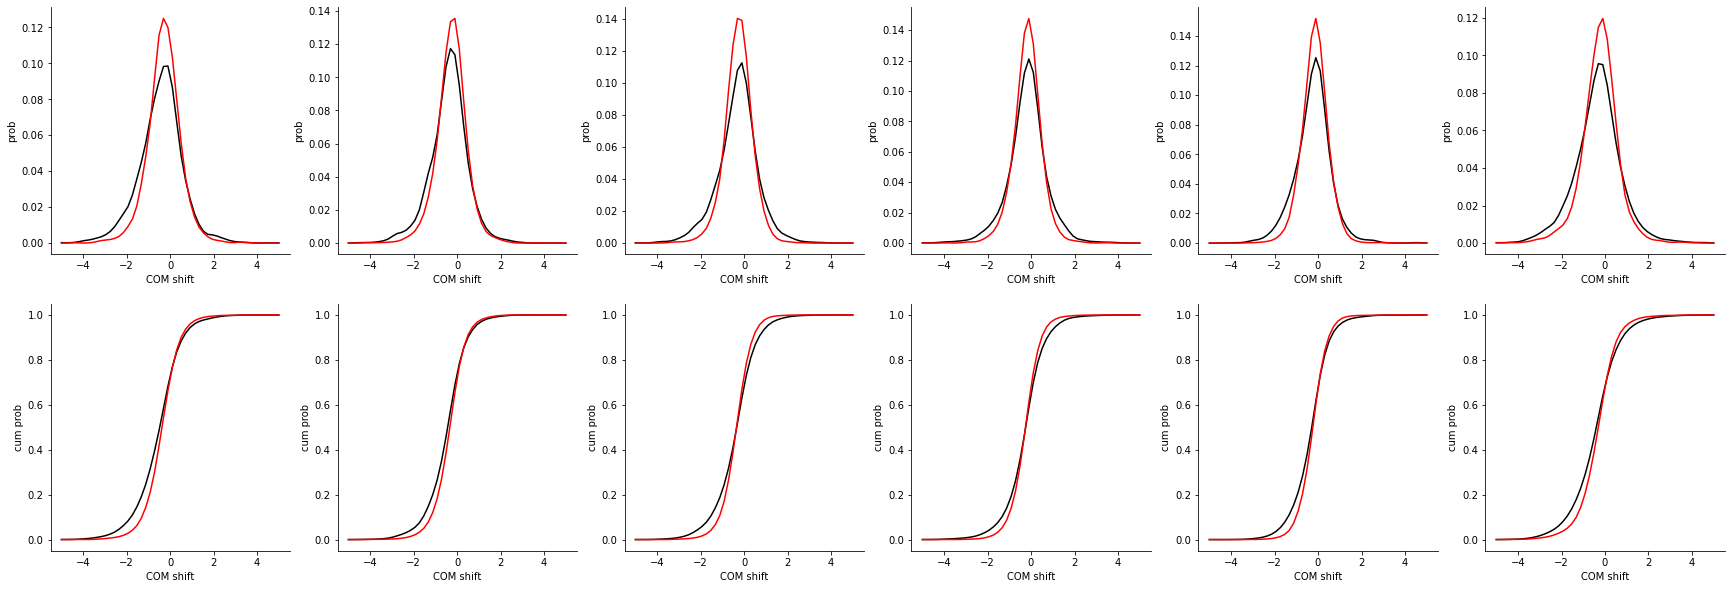

In [70]:
df_shifts = pd.DataFrame({'mouse': [],
                          'm': [],
                          'day': [],
                         'dz': [],
                         'ko': [],
                         'nov': [],
                         'nov_x_dz': [],
                         'ko_x_dz': [],
                         'ko_x_nov_x_dz':[],
                         'shifts': [],
                         'width': [],
                         'formation_lap': [],
                         'init_speed': [],
                         'init_speed_x_ko': [],
                         'field_var': [],
                         'ko_x_speed': [], 
                         'intercept': []})

fig,ax = plt.subplots(2,6, figsize= [30,10])
days_z = sp.stats.zscore(np.arange(6))
for day, dz in enumerate(days_z):
    ctrl_shifts = []
    ctrl_mu = []
    
    for m, mouse in enumerate(ctrl_mice):
        ctrl_shifts.append(ctrl_nov_shifts[mouse][day]['shift'])
        ctrl_mu.append(ctrl_nov_shifts[mouse][day]['shift'].mean())
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ctrl_nov_shifts[mouse][day]['shift'], 
                                                        ctrl_nov_shifts[mouse][day]['width'], 
                                                        ctrl_nov_shifts[mouse][day]['init_speed'],
                                                        ctrl_nov_shifts[mouse][day]['formation_lap'],
                                                        ctrl_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 1,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': dz,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ctrl_fam_shifts[mouse][day]['shift'], 
                                                        ctrl_fam_shifts[mouse][day]['width'], 
                                                        ctrl_fam_shifts[mouse][day]['init_speed'],
                                                        ctrl_fam_shifts[mouse][day]['formation_lap'],
                                                        ctrl_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m,
                                              'day': day,
                                              'dz': dz,
                                              'ko': 0,
                                              'nov': 0,
                                              'ko_x_dz': 0,
                                              'nov_x_dz': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': 0,
                                              'field_var': fvar,
                                              'ko_x_speed': 0,
                                              'intercept': 1}, ignore_index=True)
    ctrl_shifts = np.concatenate(ctrl_shifts)
    ctrl_shifts = ctrl_shifts[~np.isnan(ctrl_shifts)]
    print(np.isnan(ctrl_shifts).sum())
    
        
    ko_shifts = []
    ko_mu = []
    for m, mouse in enumerate(ko_mice):
        ko_shifts.append(ko_nov_shifts[mouse][day]['shift'])
        ko_mu.append(ko_nov_shifts[mouse][day]['shift'].mean())
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ko_nov_shifts[mouse][day]['shift'], 
                                                        ko_nov_shifts[mouse][day]['width'], 
                                                        ko_nov_shifts[mouse][day]['init_speed'],
                                                        ko_nov_shifts[mouse][day]['formation_lap'],
                                                        ko_nov_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 1,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': dz,
                                              'ko_x_nov_x_dz': 1,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': speed,
                                              'intercept': 1}, ignore_index=True)
                
        for _fn, (shift, width, speed, formlap, fvar) in enumerate(zip(ko_fam_shifts[mouse][day]['shift'], 
                                                        ko_fam_shifts[mouse][day]['width'], 
                                                        ko_fam_shifts[mouse][day]['init_speed'],
                                                        ko_fam_shifts[mouse][day]['formation_lap'],
                                                        ko_fam_shifts[mouse][day]['field_var'],)):
            if np.isnan(shift)==0:
                df_shifts = df_shifts.append({'mouse': mouse,
                                              'm': m + len(ctrl_mice),
                                              'day': day,
                                              'dz': dz,
                                              'ko': 1,
                                              'nov': 0,
                                              'ko_x_dz': dz,
                                              'nov_x_dz': 0,
                                              'ko_x_nov_x_dz': 0,
                                              'shifts': shift,
                                              'width': width,
                                              'formation_lap': formlap,
                                              'init_speed': speed,
                                              'init_speed_x_ko': speed,
                                              'field_var': fvar,
                                              'ko_x_speed': speed, 
                                              'intercept': 1}, ignore_index=True)
    ko_shifts = np.concatenate(ko_shifts)
    ko_shifts = ko_shifts[~np.isnan(ko_shifts)]

    _x = np.linspace(-5,5)
    _ctrl_hist = tpu.utilities.gaussian(ctrl_shifts[np.newaxis,:],.3, _x[:,np.newaxis]).mean(axis=1)
    _ctrl_hist /= _ctrl_hist.sum()
    ax[0,day].plot(_x,_ctrl_hist, color='black')
    ax[1,day].plot(_x,np.cumsum(_ctrl_hist), color='black')
    _ko_hist = tpu.utilities.gaussian(ko_shifts[np.newaxis,:],.3, _x[:,np.newaxis]).mean(axis=1)
    _ko_hist /= _ko_hist.sum()
    ax[0,day].plot(_x,_ko_hist, color='red')
    ax[1,day].plot(_x,np.cumsum(_ko_hist), color='red')

#     ax[0,day].vlines(ctrl_shifts.mean(),0,.09, color='black')

#     ax[0,day].vlines(ko_shifts.mean(),0,.09, color='red')

    
    ax[0,day].set_xlabel("COM shift")
    ax[0,day].set_ylabel('prob')
    ax[0,day].spines['top'].set_visible(False)
    ax[0,day].spines['right'].set_visible(False)

    
    ax[1,day].set_xlabel("COM shift")
    ax[1,day].set_ylabel('cum prob')
    ax[1,day].spines['top'].set_visible(False)
    ax[1,day].spines['right'].set_visible(False)

    t,p = sp.stats.ttest_ind(ctrl_shifts,ko_shifts)
    print(t,p)

fig.savefig(os.path.join(figdir, "com_shift_by_day.pdf"), format = 'pdf')

In [71]:
aov = mixed_anova(data=df_shifts[df_shifts['day']<2], dv='shifts', between='ko', within='day', subject='m')
print(aov)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0           ko  0.064647    1    8  0.064647  2.358296  0.163168  0.227672   
1          day  0.005644    1    8  0.005644  0.547025  0.480673  0.064002   
2  Interaction  0.000008    1    8  0.000008  0.000758  0.978716  0.000095   

   eps  
0  NaN  
1  1.0  
2  NaN  


In [72]:

df_nov = df_shifts#[df_shifts['nov']==1]
lmm_res = MixedLM(df_nov['shifts'], df_nov[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz',  'init_speed',  'init_speed_x_ko', 'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: shifts      
No. Observations:  77588   Method:             REML        
No. Groups:        10      Scale:              0.8637      
Min. group size:   2945    Log-Likelihood:     -104448.5534
Max. group size:   13705   Converged:          Yes         
Mean group size:   7758.8                                  
-----------------------------------------------------------
                Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------
ko               0.017    0.050   0.330 0.741 -0.082  0.115
dz               0.095    0.006  16.471 0.000  0.084  0.107
nov             -0.003    0.007  -0.402 0.688 -0.016  0.010
nov_x_dz        -0.042    0.007  -6.192 0.000 -0.055 -0.028
ko_x_dz         -0.023    0.007  -3.334 0.001 -0.036 -0.009
init_speed      -0.776    0.045 -17.240 0.000 -0.864 -0.688
init_speed_x_ko  0.192    0.074   2.591 0.010  0.04

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [73]:

df_nov = df_shifts#[df_shifts['nov']==1]
lmm_res = MixedLM(df_nov['shifts'], df_nov[['ko', 'dz', 'nov','nov_x_dz', 'ko_x_dz', 'init_speed',  'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shifts      
No. Observations: 77588   Method:             REML        
No. Groups:       10      Scale:              0.8637      
Min. group size:  2945    Log-Likelihood:     -104450.2231
Max. group size:  13705   Converged:          Yes         
Mean group size:  7758.8                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
ko              0.056    0.049   1.143 0.253 -0.040  0.151
dz              0.094    0.006  16.321 0.000  0.083  0.106
nov            -0.004    0.007  -0.525 0.600 -0.017  0.010
nov_x_dz       -0.041    0.007  -6.149 0.000 -0.054 -0.028
ko_x_dz        -0.020    0.007  -2.968 0.003 -0.033 -0.007
init_speed     -0.705    0.036 -19.747 0.000 -0.775 -0.635
intercept      -0.143    0.035  -4.040 0.000 -0.213 -0.074
Group Va

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [74]:
df_nov = df_shifts[df_shifts['nov']==1]
lmm_res = MixedLM(df_nov['shifts'], df_nov[['ko', 'dz', 'ko_x_dz', 'init_speed',  'intercept']], df_nov['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: shifts     
No. Observations: 36061   Method:             REML       
No. Groups:       10      Scale:              0.6844     
Min. group size:  1271    Log-Likelihood:     -44367.5334
Max. group size:  5943    Converged:          Yes        
Mean group size:  3606.1                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko              0.092    0.118  0.781 0.435 -0.139  0.324
dz              0.047    0.006  7.769 0.000  0.035  0.059
ko_x_dz        -0.016    0.009 -1.835 0.066 -0.033  0.001
init_speed     -0.259    0.047 -5.455 0.000 -0.352 -0.166
intercept      -0.250    0.084 -2.968 0.003 -0.415 -0.085
Group Var       0.035                                    



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


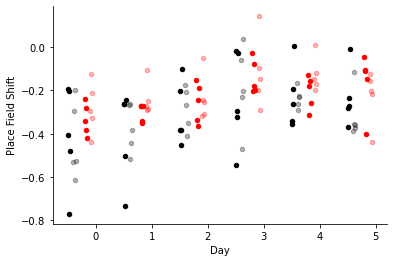

In [75]:
fig, ax = plt.subplots()

plot_arr = np.zeros([2, 2, 5, 6 ])
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==0)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,0,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 3, np.nanmean(shifts), color='red', s=20)

        
for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[0,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 1, np.nanmean(shifts), color='black', s=20, alpha = .3)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['shifts'].loc[mask ]
        plot_arr[1,1,m,day]=np.nanmean(shifts)
        ax.scatter(10*day+.1*m + 4, np.nanmean(shifts), color='red', s=20, alpha=.3)
        

ax.set_xticks(10*np.arange(6)+5)
ax.set_xticklabels(np.arange(6))
ax.set_xlabel('Day')
ax.set_ylabel('Place Field Shift')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig(os.path.join(figdir, "field_shift_summary.pdf"))

In [57]:
t,p = sp.stats.ttest_ind(plot_arr[0,0,:,1],plot_arr[1,0,:,1])
print(t,p)

-1.0080506263388878 0.3429434828154274


-0.09389328308608423 0.9251971930505488
4.889753581562016 1.0330599173335153e-06
-9.299029167721006 1.8299665836586803e-20
-4.00275191315821 6.322838547952424e-05
-10.16244429845107 4.3378150071341944e-24
-12.644876503435315 2.795077433456213e-36


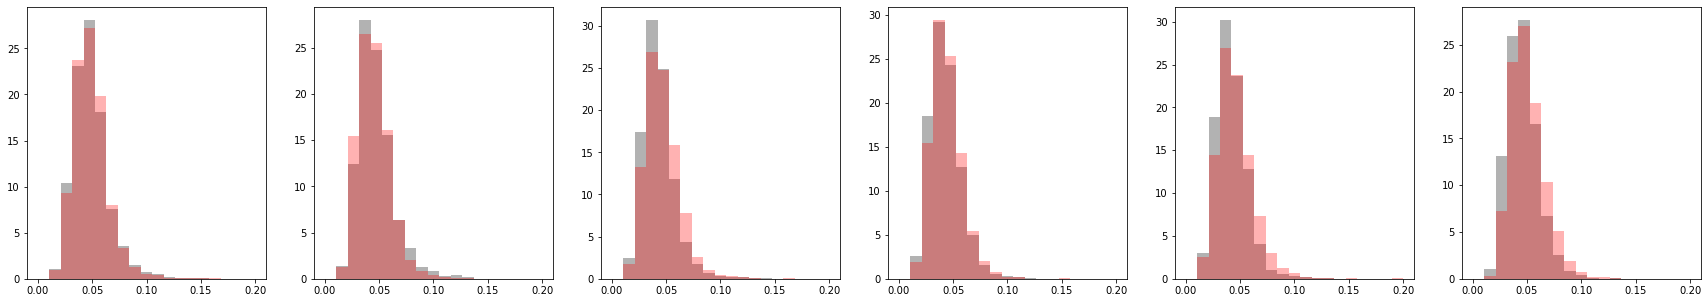

In [71]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.linspace(0,.2, num=20)
for day in range(6):
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['field_var'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) & (df_shifts['nov']==0)],
                             df_shifts['field_var'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day) & (df_shifts['nov']==0)])
    print(t,p)

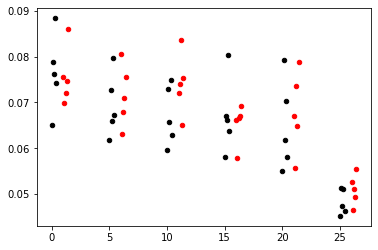

In [72]:
fig, ax = plt.subplots()

for m, mouse in enumerate(ctrl_mice):
    for day in range(6):
        mask = (df_shifts['ko']==0) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        ax.scatter(5*day+.1*m, np.nanmean(shifts), color='black', s=20)

for m, mouse in enumerate(ko_mice):
    for day in range(6):
        mask = (df_shifts['ko']==1) & (df_shifts['mouse'] == mouse) & (df_shifts['day']==day) & (df_shifts['nov']==1)
    
        shifts = df_shifts['field_var'].loc[mask ]
        ax.scatter(5*day+.1*m + 1, np.nanmean(shifts), color='red', s=20)
    

In [73]:
lmm_res = MixedLM(df_shifts['field_var'], df_shifts[['ko', 'dz', 'ko_x_dz','nov']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: field_var  
No. Observations: 77588   Method:             REML       
No. Groups:       10      Scale:              0.0004     
Min. group size:  2945    Log-Likelihood:     191672.1239
Max. group size:  13705   Converged:          Yes        
Mean group size:  7758.8                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko             0.046    0.015   3.135 0.002  0.017  0.075
dz            -0.004    0.000 -43.100 0.000 -0.005 -0.004
ko_x_dz        0.001    0.000   8.266 0.000  0.001  0.002
nov            0.021    0.000 139.565 0.000  0.020  0.021
Group Var      0.001    0.024                            



/home/mplitt/anaconda3/envs/STX3_test/lib/python3.8/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


0.17336662155817864 2.6570617326069377e-165
0.19495241401729893 1.9516247710786806e-174


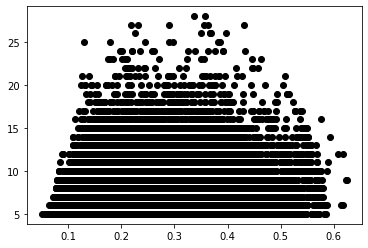

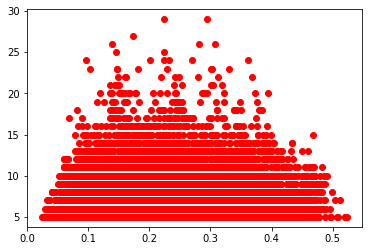

In [26]:
fig, ax = plt.subplots()
ctrl_df = df_shifts[df_shifts['ko']==0]
ax.scatter(ctrl_df['init_speed'],ctrl_df['width'], color='black')
r,p = sp.stats.pearsonr(ctrl_df['init_speed'],ctrl_df['width'])
print(r,p)

fig, ax = plt.subplots()
ko_df = df_shifts[df_shifts['ko']==1]
ax.scatter(ko_df['init_speed'],ko_df['width'], color='red')
r,p = sp.stats.pearsonr(ko_df['init_speed'],ko_df['width'])
print(r,p)

In [71]:
speed_z = sp.stats.zscore(df_shifts['init_speed']._values)
df_shifts['init_speed'] = speed_z
df_shifts['ko_x_speed'] = speed_z*df_shifts['ko']._values
lmm_res = MixedLM(df_shifts['width'], df_shifts[['ko', 'dz', 'ko_x_dz','init_speed', 'ko_x_speed']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())



          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: width      
No. Observations: 14313   Method:             REML       
No. Groups:       10      Scale:              5.5196     
Min. group size:  484     Log-Likelihood:     -32586.2064
Max. group size:  2073    Converged:          Yes        
Mean group size:  1431.3                                 
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
ko              7.829    2.741  2.856 0.004  2.457 13.201
dz              0.218    0.024  8.925 0.000  0.170  0.266
ko_x_dz        -0.118    0.041 -2.888 0.004 -0.197 -0.038
init_speed      0.471    0.027 17.759 0.000  0.419  0.523
ko_x_speed     -0.079    0.048 -1.632 0.103 -0.174  0.016
Group Var      37.558    7.268                           



5.773612624611505 9.079796606599732e-09
4.888152400451535 1.095548468597884e-06
5.270232628479259 1.4956091386874433e-07
5.9048277000737786 4.049025830261659e-09
3.509481656130859 0.00045783820864629904
1.3679174231110098 0.17142311390123907


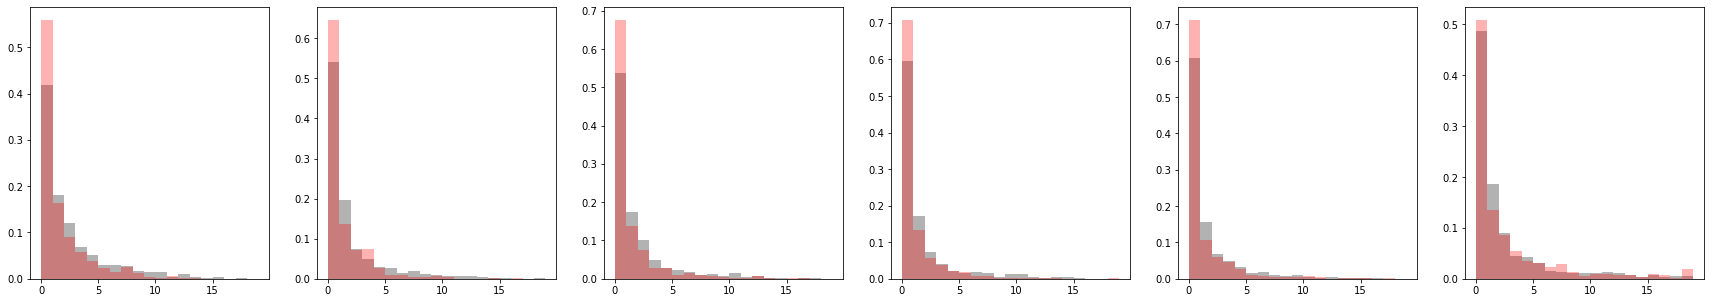

In [74]:
fig,ax = plt.subplots(1,6, figsize = [30,5])

bins = np.arange(20)
for day in range(6):
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day) ],
                 bins = bins, color = 'black', alpha = .3, density=True)
    ax[day].hist(df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)],
                 bins = bins, color = 'red', alpha = .3, density=True)
    t,p = sp.stats.ttest_ind(df_shifts['formation_lap'].loc[(df_shifts['ko']==0) & (df_shifts['day']==day)],
                             df_shifts['formation_lap'].loc[(df_shifts['ko']==1) & (df_shifts['day']==day)])
    print(t,p)

In [75]:
lmm_res = MixedLM(df_shifts['formation_lap'], df_shifts[['ko', 'dz', 'ko_x_dz']], df_shifts['mouse'])
lmm_resf = lmm_res.fit()
print(lmm_resf.summary())

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: formation_lap
No. Observations: 14313   Method:             REML         
No. Groups:       10      Scale:              24.8484      
Min. group size:  484     Log-Likelihood:     -43328.0547  
Max. group size:  2073    Converged:          Yes          
Mean group size:  1431.3                                   
------------------------------------------------------------
              Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------
ko            1.501     0.727   2.064  0.039   0.076   2.926
dz            0.693     0.051  13.459  0.000   0.592   0.794
ko_x_dz       0.225     0.085   2.648  0.008   0.059   0.392
Group Var     2.615     0.249                               

